In [48]:
%pip install opencv-python numpy matplotlib tqdm -q

Note: you may need to restart the kernel to use updated packages.


# Imports and main logic

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm

In [3]:
def find_brightness_values(video_path):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    frame_brightness_values = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        current_frame_brightness = np.mean(gray_frame)
        frame_brightness_values.append(current_frame_brightness)
    
    return frame_brightness_values

def detect_lightning_flashes(frame_brightness_values, frame_rate=30):
    # Calculate mean and standard deviation of brightness
    mean_brightness = np.mean(frame_brightness_values)
    std_brightness = np.std(frame_brightness_values)
    
    # Remove outliers (exceptionally bright frames)
    upper_limit = mean_brightness + 3 * std_brightness
    filtered_brightness = [b for b in frame_brightness_values if b <= upper_limit]
    
    # Recalculate mean and standard deviation without outliers
    filtered_mean = np.mean(filtered_brightness)
    filtered_std = np.std(filtered_brightness)
    
    # Set dynamic threshold with lower multiplier
    threshold = filtered_mean + 1.5 * filtered_std
    flash_timestamps = []
    # Detect flashes based on gathered brightness values
    previous_brightness = None
    for i, current_frame_brightness in enumerate(frame_brightness_values):
        # Check for significant brightness increase
        if previous_brightness is not None:
            brightness_increase = current_frame_brightness - previous_brightness
            if brightness_increase > 2 * filtered_std and current_frame_brightness > threshold:
                timestamp = i / frame_rate  # Convert frame number to seconds
                flash_timestamps.append(timestamp)
                minutes = int(timestamp // 60)
                seconds = int(timestamp % 60)
                print(f"Flash detected at {minutes}:{seconds:02d} minutes")

        previous_brightness = current_frame_brightness
    return flash_timestamps


In [5]:
def cut_video_clips(video_path, flash_timestamps):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_filename = f"./combined_cuts_{os.path.basename(video_path)}"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, frame_rate, (width, height))

    # Gather and merge overlapping timestamp pairs
    clip_timestamps = []
    i = 0
    while i < len(flash_timestamps):
        start_timestamp = max(0, flash_timestamps[i] - 3)  # Add 3 seconds before
        end_timestamp = flash_timestamps[i] + 3  # Add 3 seconds after

        # Merge overlapping intervals
        while i + 1 < len(flash_timestamps) and flash_timestamps[i + 1] - 3 <= end_timestamp:
            end_timestamp = flash_timestamps[i + 1] + 3
            i += 1

        clip_timestamps.append((start_timestamp, end_timestamp))
        i += 1

    # Cut the resulting video
    for clip_num, (start_timestamp, end_timestamp) in enumerate(clip_timestamps, 1):
        start_frame = int(start_timestamp * frame_rate)
        end_frame = int(end_timestamp * frame_rate)

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(end_frame - start_frame):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)

        print(f"Added clip {clip_num} to combined video")

    out.release()
    cap.release()
    print(f"Saved combined video: {output_filename}")

def plot_brightness_over_time(frame_brightness, threshold, frame_rate=30):
    # Plot the brightness over time
    time_stamps = [i / frame_rate for i in range(len(frame_brightness))]
    plt.figure(figsize=(12, 6))
    plt.plot(time_stamps, frame_brightness, label='Frame Brightness', color='blue')
    if threshold > 0:
        plt.axhline(y=threshold, color='red', linestyle='--', label='Dynamic Brightness Threshold')
    plt.title('Frame Brightness Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Brightness')
    plt.legend()
    plt.grid()
    plt.show()

def merge_combined_videos(folder_path):
    combined_videos = [f for f in os.listdir(folder_path) if f.startswith('combined_') and f.endswith('.mp4')]

    if combined_videos:
        output_path = os.path.join(folder_path, 'final_combined_video.mp4')
        
        # Get video properties from the first video
        first_video = cv2.VideoCapture(os.path.join(folder_path, combined_videos[0]))
        fps = first_video.get(cv2.CAP_PROP_FPS)
        width = int(first_video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(first_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        first_video.release()

        # Create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        for video in combined_videos:
            cap = cv2.VideoCapture(os.path.join(folder_path, video))
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                out.write(frame)
            cap.release()

        out.release()
        print(f"All combined videos have been merged into: {output_path}")
    else:
        print("No combined videos found to merge.")
        
def process_videos(folder_path):
    # Get all video paths in the folder
    video_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
    
    for video_path in video_paths:
        # Find brightness values
        frame_brightness_values = find_brightness_values(video_path)
        
        # Detect lightning flashes
        flash_timestamps = detect_lightning_flashes(frame_brightness_values)
        
        # Cut video clips
        cut_video_clips(video_path, flash_timestamps)
        
        # Plot brightness over time (optional)
        plot_brightness_over_time(frame_brightness_values, 0)
    
    # Merge all combined videos
    merge_combined_videos("./")


# Testing

Flash detected at 23:15 minutes


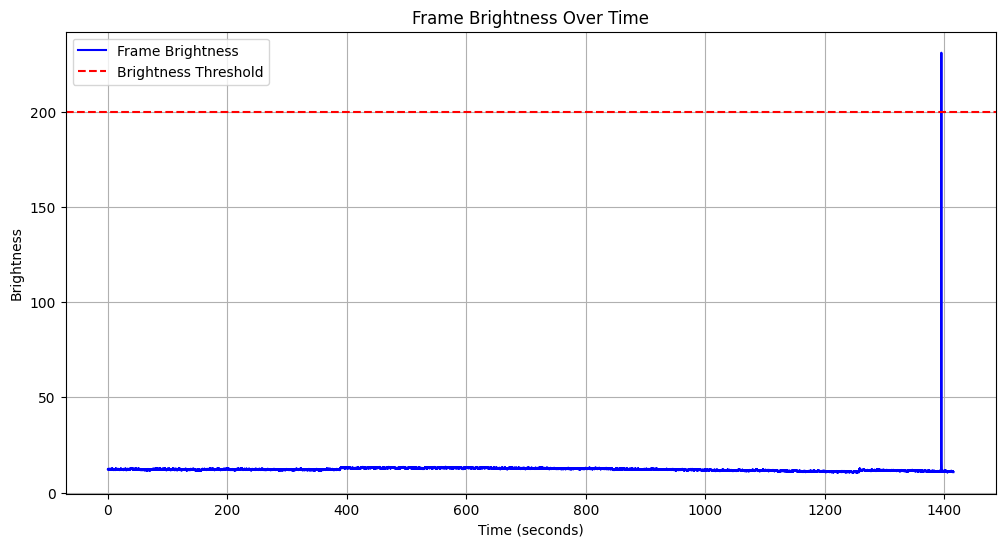

Detected flash timestamps (minutes:seconds):
23:15


In [78]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_161027440.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


Flash detected at 1:03 minutes
Flash detected at 1:04 minutes
Flash detected at 1:04 minutes
Flash detected at 1:28 minutes
Flash detected at 1:29 minutes
Flash detected at 1:29 minutes
Flash detected at 1:29 minutes
Flash detected at 1:29 minutes
Flash detected at 1:29 minutes
Flash detected at 2:17 minutes
Flash detected at 3:59 minutes
Flash detected at 3:59 minutes


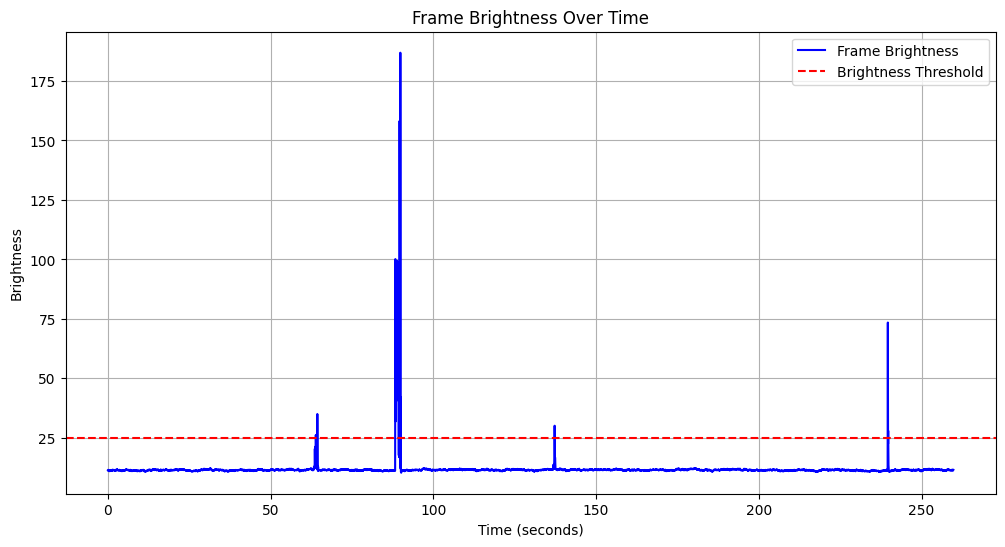

Detected flash timestamps (minutes:seconds):
1:03
1:04
1:04
1:28
1:29
1:29
1:29
1:29
1:29
2:17
3:59
3:59


In [81]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_174334761.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


Flash detected at 1:29 minutes
Flash detected at 1:29 minutes
Flash detected at 1:29 minutes
Flash detected at 1:30 minutes
Flash detected at 1:30 minutes
Flash detected at 1:30 minutes
Flash detected at 1:30 minutes
Flash detected at 1:30 minutes
Flash detected at 1:31 minutes
Flash detected at 1:31 minutes
Flash detected at 1:31 minutes
Flash detected at 1:31 minutes
Flash detected at 1:32 minutes
Flash detected at 2:27 minutes
Flash detected at 3:30 minutes
Flash detected at 3:31 minutes
Flash detected at 4:02 minutes
Flash detected at 5:28 minutes
Flash detected at 5:28 minutes
Flash detected at 5:29 minutes
Flash detected at 5:47 minutes
Flash detected at 8:37 minutes
Flash detected at 8:37 minutes
Flash detected at 8:38 minutes


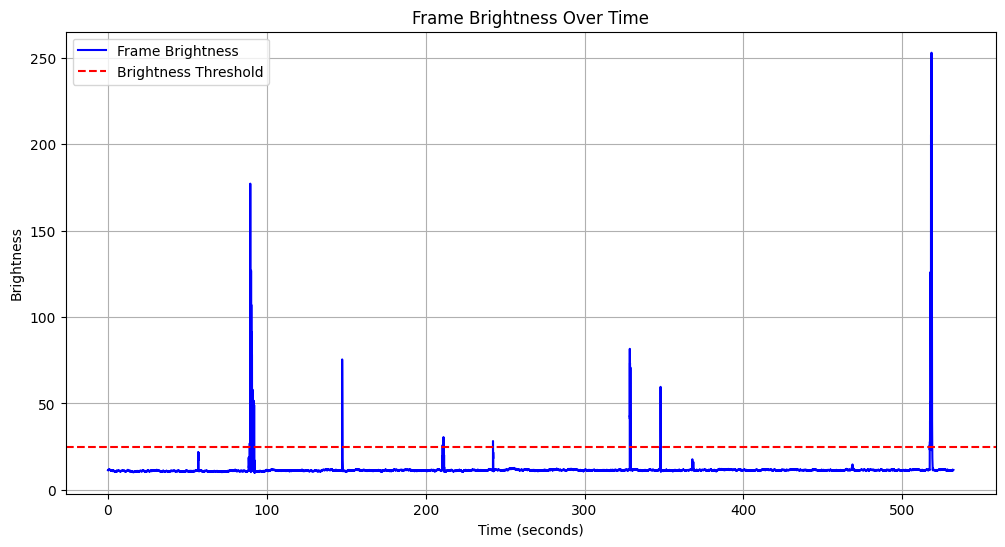

Detected flash timestamps (minutes:seconds):
1:29
1:29
1:29
1:30
1:30
1:30
1:30
1:30
1:31
1:31
1:31
1:31
1:32
2:27
3:30
3:31
4:02
5:28
5:28
5:29
5:47
8:37
8:37
8:38


In [82]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_174441453.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


Flash detected at 2:04 minutes
Flash detected at 2:05 minutes
Flash detected at 3:15 minutes
Flash detected at 3:26 minutes
Flash detected at 3:26 minutes
Flash detected at 3:26 minutes
Flash detected at 8:58 minutes
Flash detected at 12:38 minutes
Flash detected at 13:37 minutes
Flash detected at 13:38 minutes
Flash detected at 13:39 minutes
Flash detected at 13:40 minutes
Flash detected at 13:40 minutes
Flash detected at 13:40 minutes
Flash detected at 13:40 minutes
Flash detected at 13:41 minutes


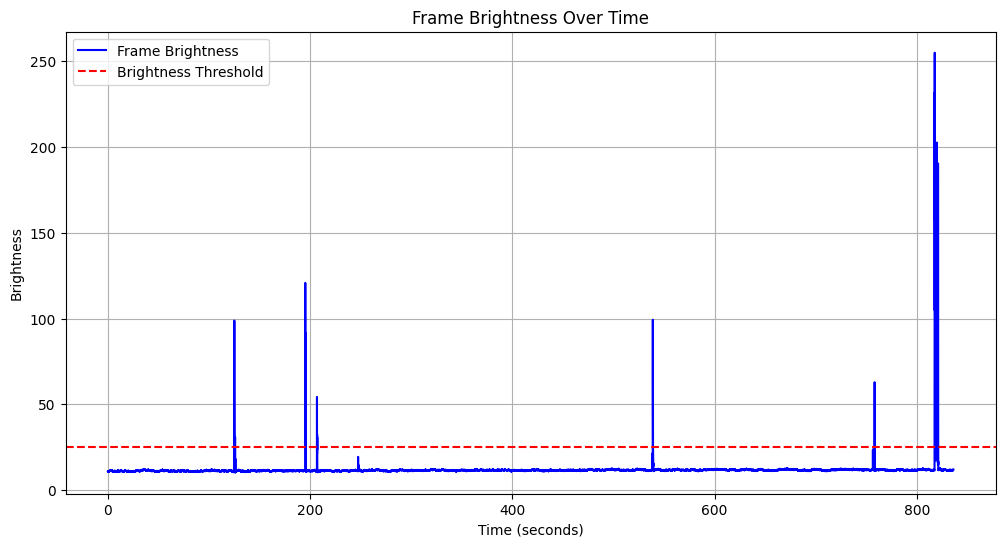

Detected flash timestamps (minutes:seconds):
2:04
2:05
3:15
3:26
3:26
3:26
8:58
12:38
13:37
13:38
13:39
13:40
13:40
13:40
13:40
13:41


In [83]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_174656356.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


Flash detected at 1:06 minutes
Flash detected at 1:06 minutes
Flash detected at 1:47 minutes
Flash detected at 1:47 minutes
Flash detected at 1:47 minutes
Flash detected at 1:48 minutes
Flash detected at 5:22 minutes
Flash detected at 5:24 minutes
Flash detected at 9:10 minutes
Flash detected at 9:10 minutes
Flash detected at 9:11 minutes
Flash detected at 9:11 minutes
Flash detected at 9:11 minutes
Flash detected at 9:11 minutes
Flash detected at 12:59 minutes
Flash detected at 12:59 minutes
Flash detected at 12:59 minutes
Flash detected at 13:00 minutes
Flash detected at 18:49 minutes
Flash detected at 18:50 minutes
Flash detected at 25:29 minutes
Flash detected at 28:54 minutes
Flash detected at 28:54 minutes
Flash detected at 28:54 minutes
Flash detected at 28:54 minutes
Flash detected at 28:55 minutes


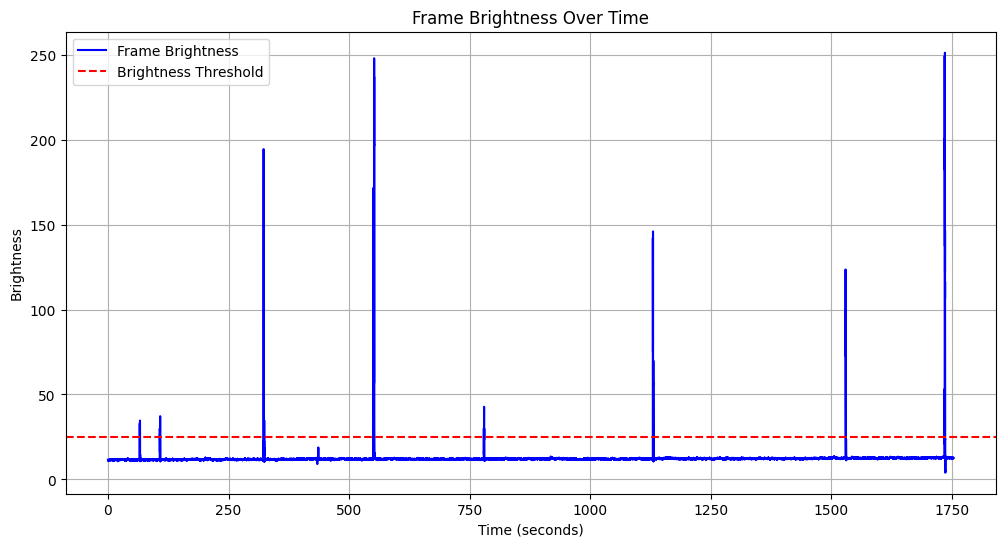

Detected flash timestamps (minutes:seconds):
1:06
1:06
1:47
1:47
1:47
1:48
5:22
5:24
9:10
9:10
9:11
9:11
9:11
9:11
12:59
12:59
12:59
13:00
18:49
18:50
25:29
28:54
28:54
28:54
28:54
28:55


In [84]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_175029730.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


Flash detected at 0:29 minutes
Flash detected at 0:29 minutes
Flash detected at 0:29 minutes
Flash detected at 0:30 minutes
Flash detected at 0:30 minutes
Flash detected at 4:30 minutes
Flash detected at 4:30 minutes
Flash detected at 4:30 minutes
Flash detected at 4:31 minutes
Flash detected at 4:32 minutes
Flash detected at 4:32 minutes
Flash detected at 4:32 minutes


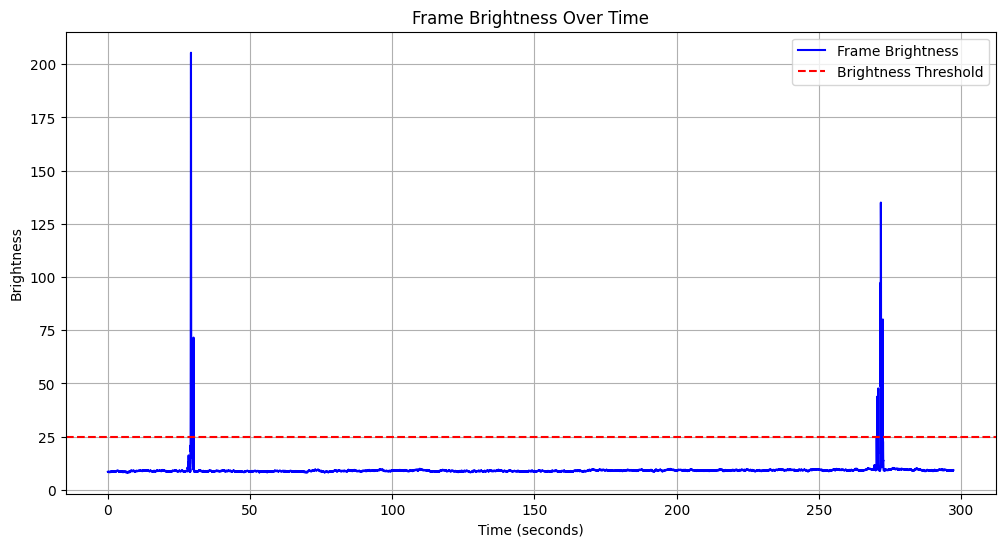

Detected flash timestamps (minutes:seconds):
0:29
0:29
0:29
0:30
0:30
4:30
4:30
4:30
4:31
4:32
4:32
4:32


In [85]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_180051449.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


Flash detected at 3:01 minutes
Flash detected at 3:02 minutes
Flash detected at 4:42 minutes
Flash detected at 4:43 minutes
Flash detected at 4:43 minutes
Flash detected at 4:43 minutes
Flash detected at 4:57 minutes
Flash detected at 4:57 minutes


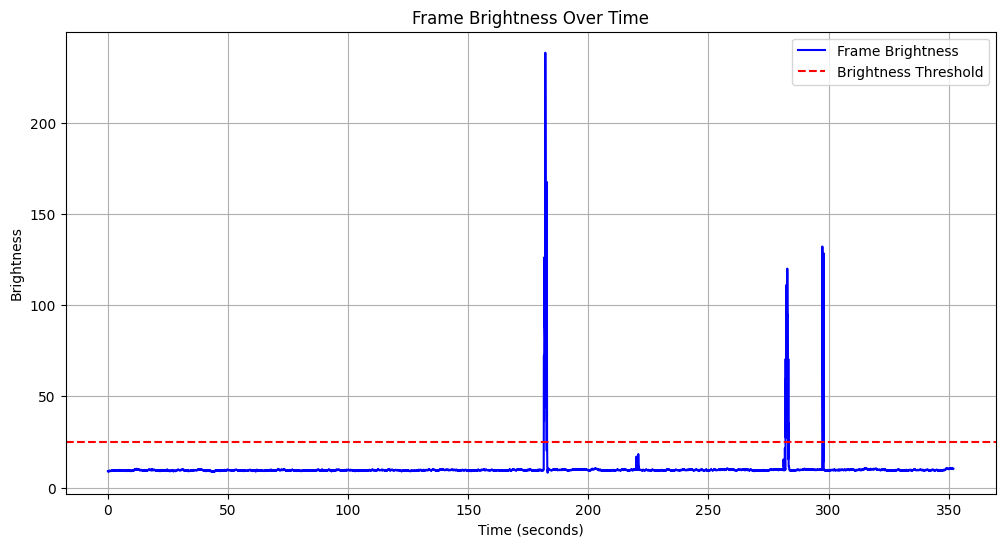

Detected flash timestamps (minutes:seconds):
3:01
3:02
4:42
4:43
4:43
4:43
4:57
4:57


In [86]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_180227402.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


Flash detected at 2:20 minutes
Flash detected at 2:21 minutes
Flash detected at 6:35 minutes
Flash detected at 11:37 minutes
Flash detected at 11:37 minutes
Flash detected at 11:37 minutes
Flash detected at 11:38 minutes
Flash detected at 11:38 minutes


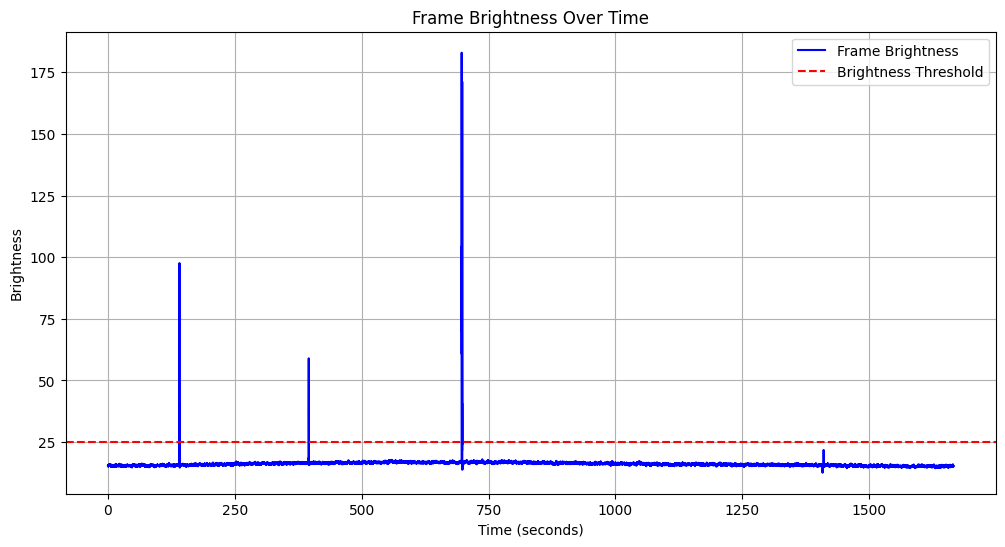

Detected flash timestamps (minutes:seconds):
2:20
2:21
6:35
11:37
11:37
11:37
11:38
11:38


In [87]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_180404869.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


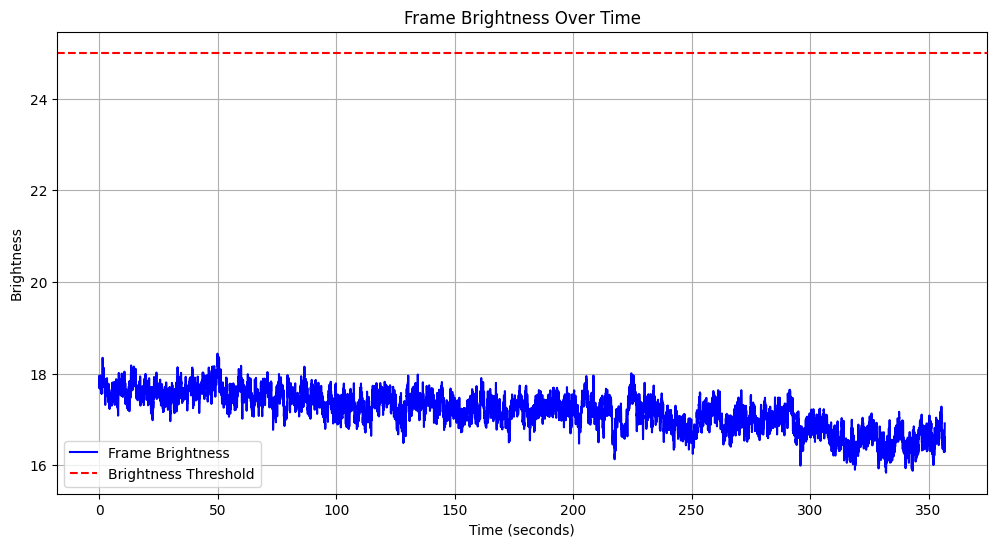

Detected flash timestamps (minutes:seconds):


In [88]:
# Example usage
video_path = 'C:\\Users\\user\\Pictures\\pixel\\slowmo and more\\PXL_20240923_181105972.mp4'
flashes = detect_lightning_flashes_and_plot_brightness(video_path, 25)

# Print all detected flash timestamps in minute:second format
print("Detected flash timestamps (minutes:seconds):")
for timestamp in flashes:
    minutes = int(timestamp // 60)
    seconds = int(timestamp % 60)
    print(f"{minutes}:{seconds:02d}")


# New testing

Flash detected at 2:07 minutes
Flash detected at 2:07 minutes
Flash detected at 2:07 minutes
Flash detected at 2:07 minutes
Flash detected at 2:08 minutes
Flash detected at 2:08 minutes
Flash detected at 2:08 minutes
Flash detected at 2:09 minutes
Flash detected at 2:09 minutes
Flash detected at 2:09 minutes
Flash detected at 2:09 minutes
Flash detected at 2:10 minutes
Flash detected at 2:10 minutes
Flash detected at 2:10 minutes
Flash detected at 2:10 minutes
Flash detected at 4:00 minutes
Flash detected at 4:28 minutes
Flash detected at 4:28 minutes
Flash detected at 4:28 minutes
Flash detected at 4:28 minutes
Flash detected at 4:28 minutes
Flash detected at 4:28 minutes
Flash detected at 4:28 minutes
Flash detected at 4:30 minutes
Added clip 1 to combined video
Added clip 2 to combined video
Added clip 3 to combined video
Saved combined video: ./combined_cuts_PXL_20241008_141043591.mp4


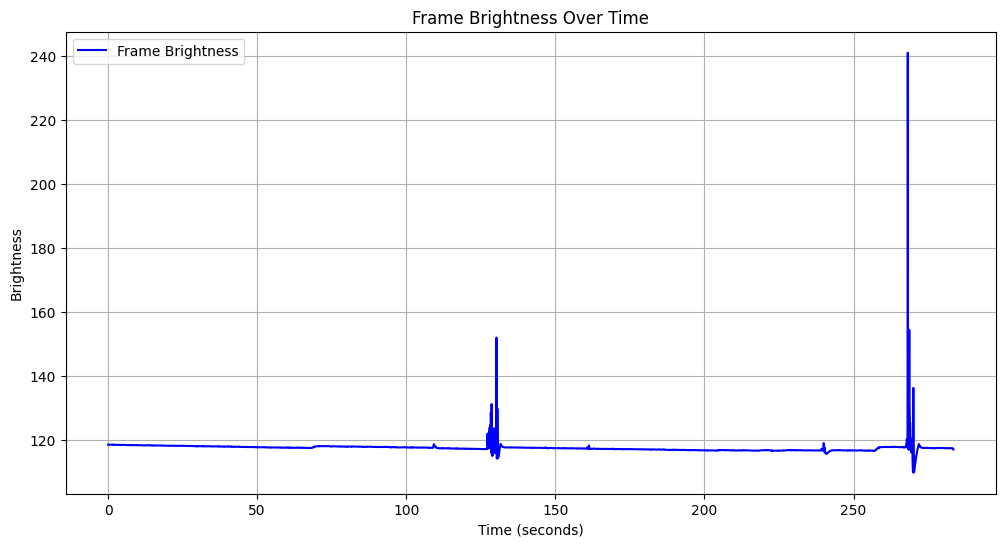

Flash detected at 2:09 minutes
Flash detected at 2:09 minutes
Flash detected at 2:10 minutes
Flash detected at 5:36 minutes
Flash detected at 5:37 minutes
Flash detected at 5:37 minutes
Added clip 1 to combined video
Added clip 2 to combined video
Saved combined video: ./combined_cuts_PXL_20241008_141158794.mp4


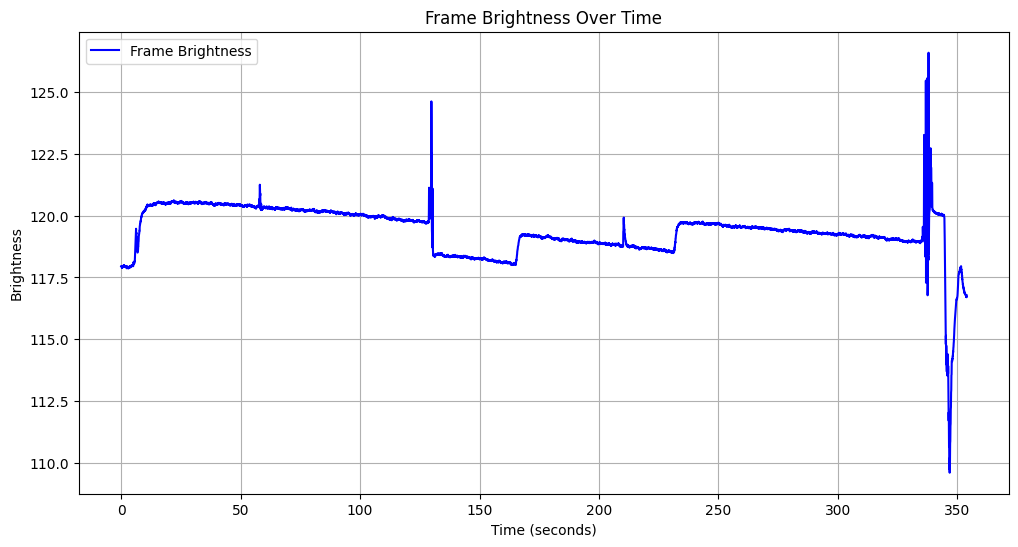

Flash detected at 1:29 minutes
Flash detected at 1:30 minutes
Flash detected at 1:30 minutes
Flash detected at 1:31 minutes
Flash detected at 1:31 minutes
Flash detected at 3:57 minutes
Flash detected at 4:36 minutes
Flash detected at 4:36 minutes
Flash detected at 4:36 minutes
Flash detected at 4:37 minutes
Flash detected at 4:38 minutes
Flash detected at 4:38 minutes
Flash detected at 4:38 minutes
Flash detected at 5:28 minutes
Flash detected at 5:30 minutes
Flash detected at 5:30 minutes
Flash detected at 5:30 minutes
Flash detected at 8:17 minutes
Flash detected at 8:18 minutes
Flash detected at 8:18 minutes
Flash detected at 8:19 minutes
Flash detected at 8:19 minutes
Flash detected at 9:41 minutes
Flash detected at 9:41 minutes
Flash detected at 9:41 minutes
Flash detected at 11:04 minutes
Flash detected at 11:05 minutes
Flash detected at 11:05 minutes
Flash detected at 11:05 minutes
Flash detected at 11:05 minutes
Flash detected at 12:49 minutes
Flash detected at 14:35 minutes
F

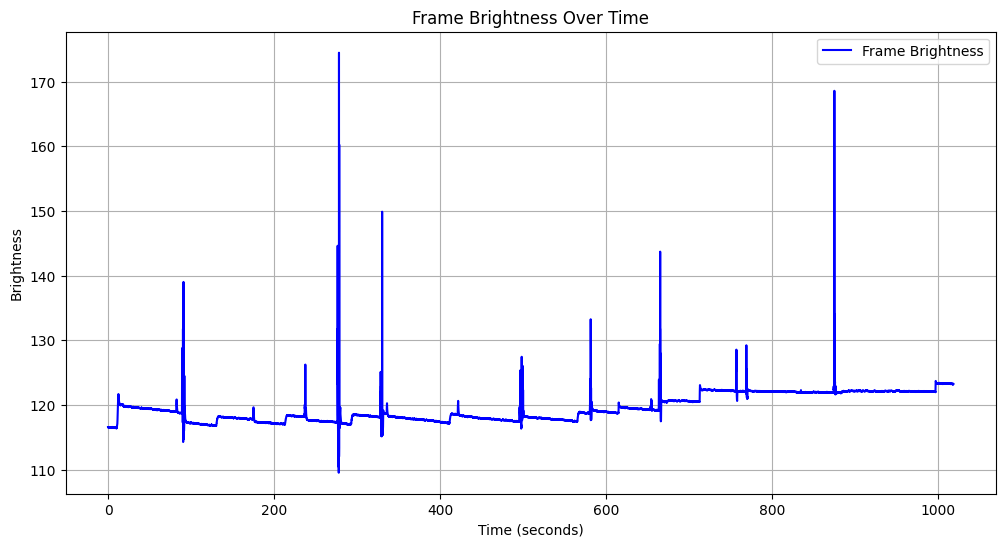

Flash detected at 1:36 minutes
Flash detected at 1:37 minutes
Flash detected at 1:37 minutes
Flash detected at 1:37 minutes
Flash detected at 1:37 minutes
Flash detected at 2:22 minutes
Flash detected at 2:23 minutes
Flash detected at 2:23 minutes
Flash detected at 5:35 minutes
Flash detected at 5:36 minutes
Flash detected at 5:36 minutes
Flash detected at 5:36 minutes
Flash detected at 8:53 minutes
Flash detected at 8:54 minutes
Flash detected at 8:54 minutes
Flash detected at 8:55 minutes
Flash detected at 8:55 minutes
Flash detected at 8:55 minutes
Flash detected at 8:55 minutes
Flash detected at 8:55 minutes
Flash detected at 12:05 minutes
Flash detected at 15:05 minutes
Flash detected at 15:05 minutes
Flash detected at 15:07 minutes
Flash detected at 15:07 minutes
Flash detected at 15:08 minutes
Flash detected at 15:08 minutes
Flash detected at 15:08 minutes
Flash detected at 15:08 minutes
Flash detected at 15:08 minutes
Flash detected at 15:08 minutes
Flash detected at 15:08 minu

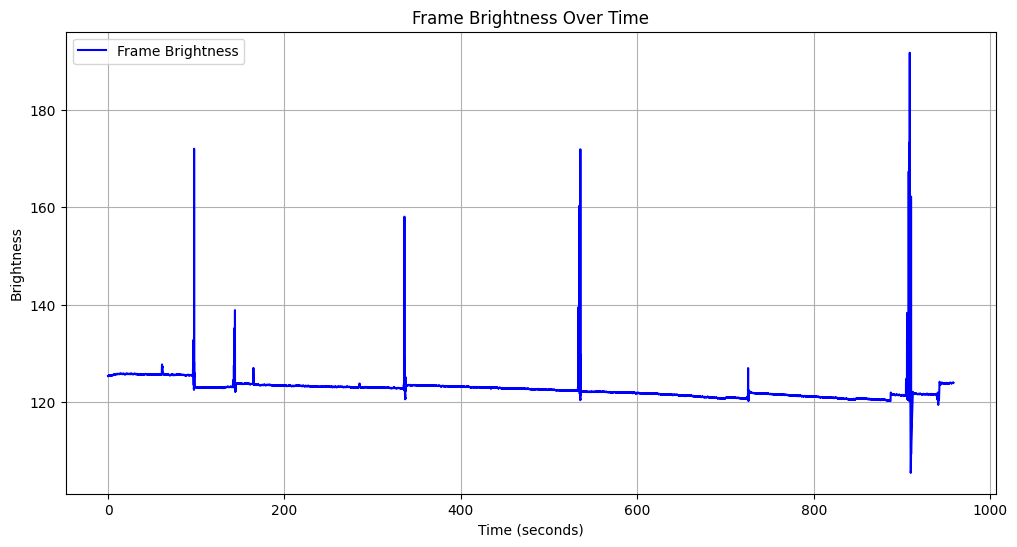

Flash detected at 7:40 minutes
Added clip 1 to combined video
Saved combined video: ./combined_cuts_PXL_20241008_142202180.mp4


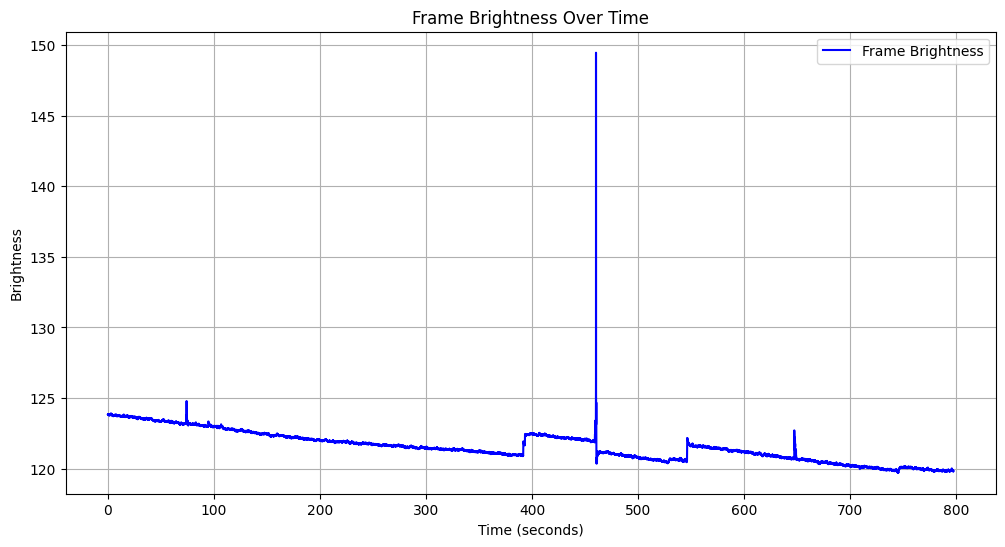

Flash detected at 3:37 minutes
Flash detected at 4:14 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:16 minutes
Flash detected at 4:17 minutes
Flash detected at 4:17 minutes
Flash detected at 4:17 minutes
Flash detected at 4:17 minutes
Flash detected at 8:43 minutes
Flash detected at 16:59 minutes
Flash detected at 17:00 minutes
Flash detected at 17:00 minutes
Flash detected at 17:00 minutes
Flash detected at 17:00 minutes
Flash detected at 17:00 minutes
Flash detected at 17:01 minutes
Added clip 1 to combined video
Added clip 2 to combined video
Added clip 3 to combined video
Added clip 4 to combined video
Saved combined video: ./combined_cuts_PXL_20241008_142631168.mp4


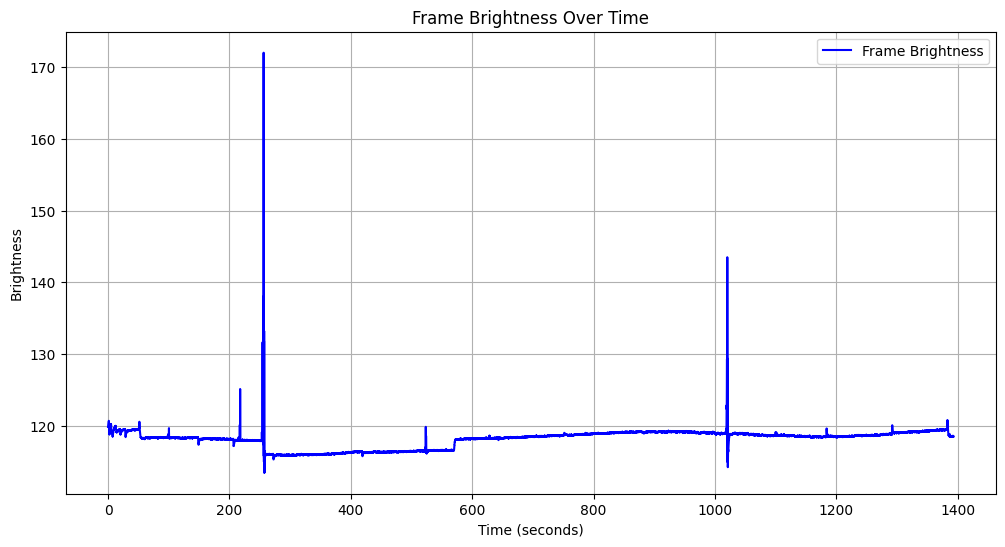

Saved combined video: ./combined_cuts_PXL_20241008_144819252.mp4


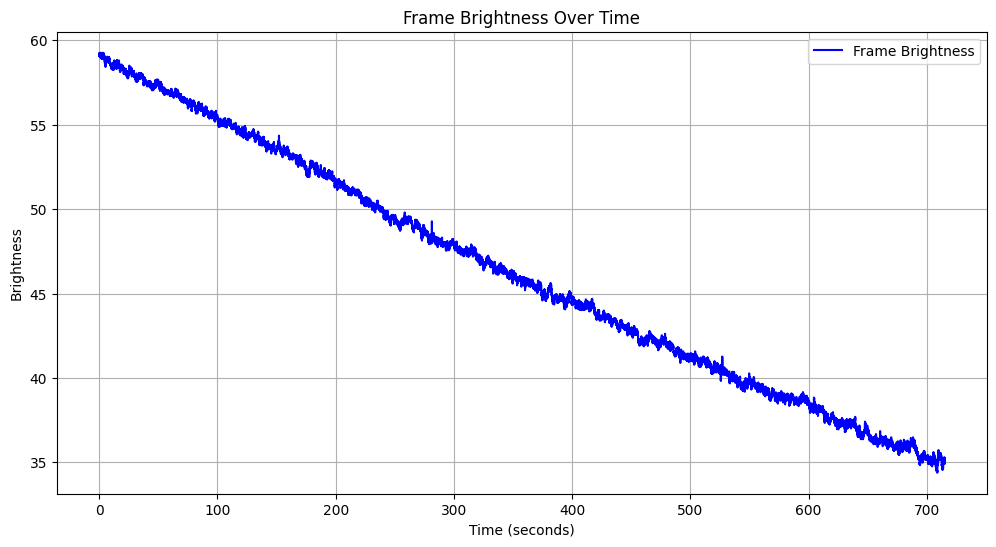

No combined videos found to merge.


In [7]:
folder_path = r'C:\Users\user\Pictures\photos'
process_videos(folder_path)

In [8]:
merge_combined_videos("./")

All combined videos have been merged into: ./final_combined_video.mp4
